
# Introduction

Ici on explique que faire la compétition en P3A ça a servi de pretexte pour se confronter à différents aspect du machine learning et de s'intérroger sur les aspects pratiques et théoriques de certaines méthodes.

During our projet 3A, we participed in a kaggle competition named blabla.

# Data exploration and analysis

Un petit blabla d'introduction

## Features distributions

On etudie les distributions, le mieux étant d'avoir quelque chose de centré, symetrique...
Détailler l'utilisation de la fonction skew de scipy.stat pour déterminé sur qui appliquer le log.
Détaillé aussi les formules qui explique pourquoi le log.

In [14]:
from __future__ import division, print_function
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try :
    import seaborn as sns; sns.set()
except ImportError:
    print("seaborn not found on your computer. "
          "Install it if you want pretty charts \n"
          "If you have internet access you can run in a cell : \n"
          "!pip install -U seaborn ")

pd.set_option('display.max_columns', None)
%matplotlib inline


In [64]:
train = pd.read_csv("train.csv",index_col = 0)
train.loc[train['PoolQC'].isnull(),'PoolQC'] = 'N.a'
train.loc[train['Fence'].isnull(),'Fence'] = 'N.a'
train.loc[train['MiscFeature'].isnull(),'MiscFeature'] = 'N.a'
train.loc[train['GarageCond'].isnull(),'GarageCond'] = 'N.a'
train.loc[train['GarageQual'].isnull(),'GarageQual'] = 'N.a'
train.loc[train['GarageFinish'].isnull(),'GarageFinish'] = 'N.a'
train.loc[train['GarageType'].isnull(),'GarageType'] = 'N.a'
train.loc[train['FireplaceQu'].isnull(),'FireplaceQu'] = 'N.a'
train.loc[train['BsmtFinType2'].isnull(),'BsmtFinType2'] = 'N.a'
train.loc[train['BsmtFinType1'].isnull(),'BsmtFinType1'] = 'N.a'
train.loc[train['BsmtExposure'].isnull(),'BsmtExposure'] = 'N.a'
train.loc[train['BsmtCond'].isnull(),'BsmtCond'] = 'N.a'
train.loc[train['BsmtQual'].isnull(),'BsmtQual'] = 'N.a'
train.loc[train['Alley'].isnull(),'Alley'] = 'N.a'

y_tr = train['SalePrice']
X_tr = train.drop('SalePrice',axis = 1)


Let's look at the distribution of the differents features.

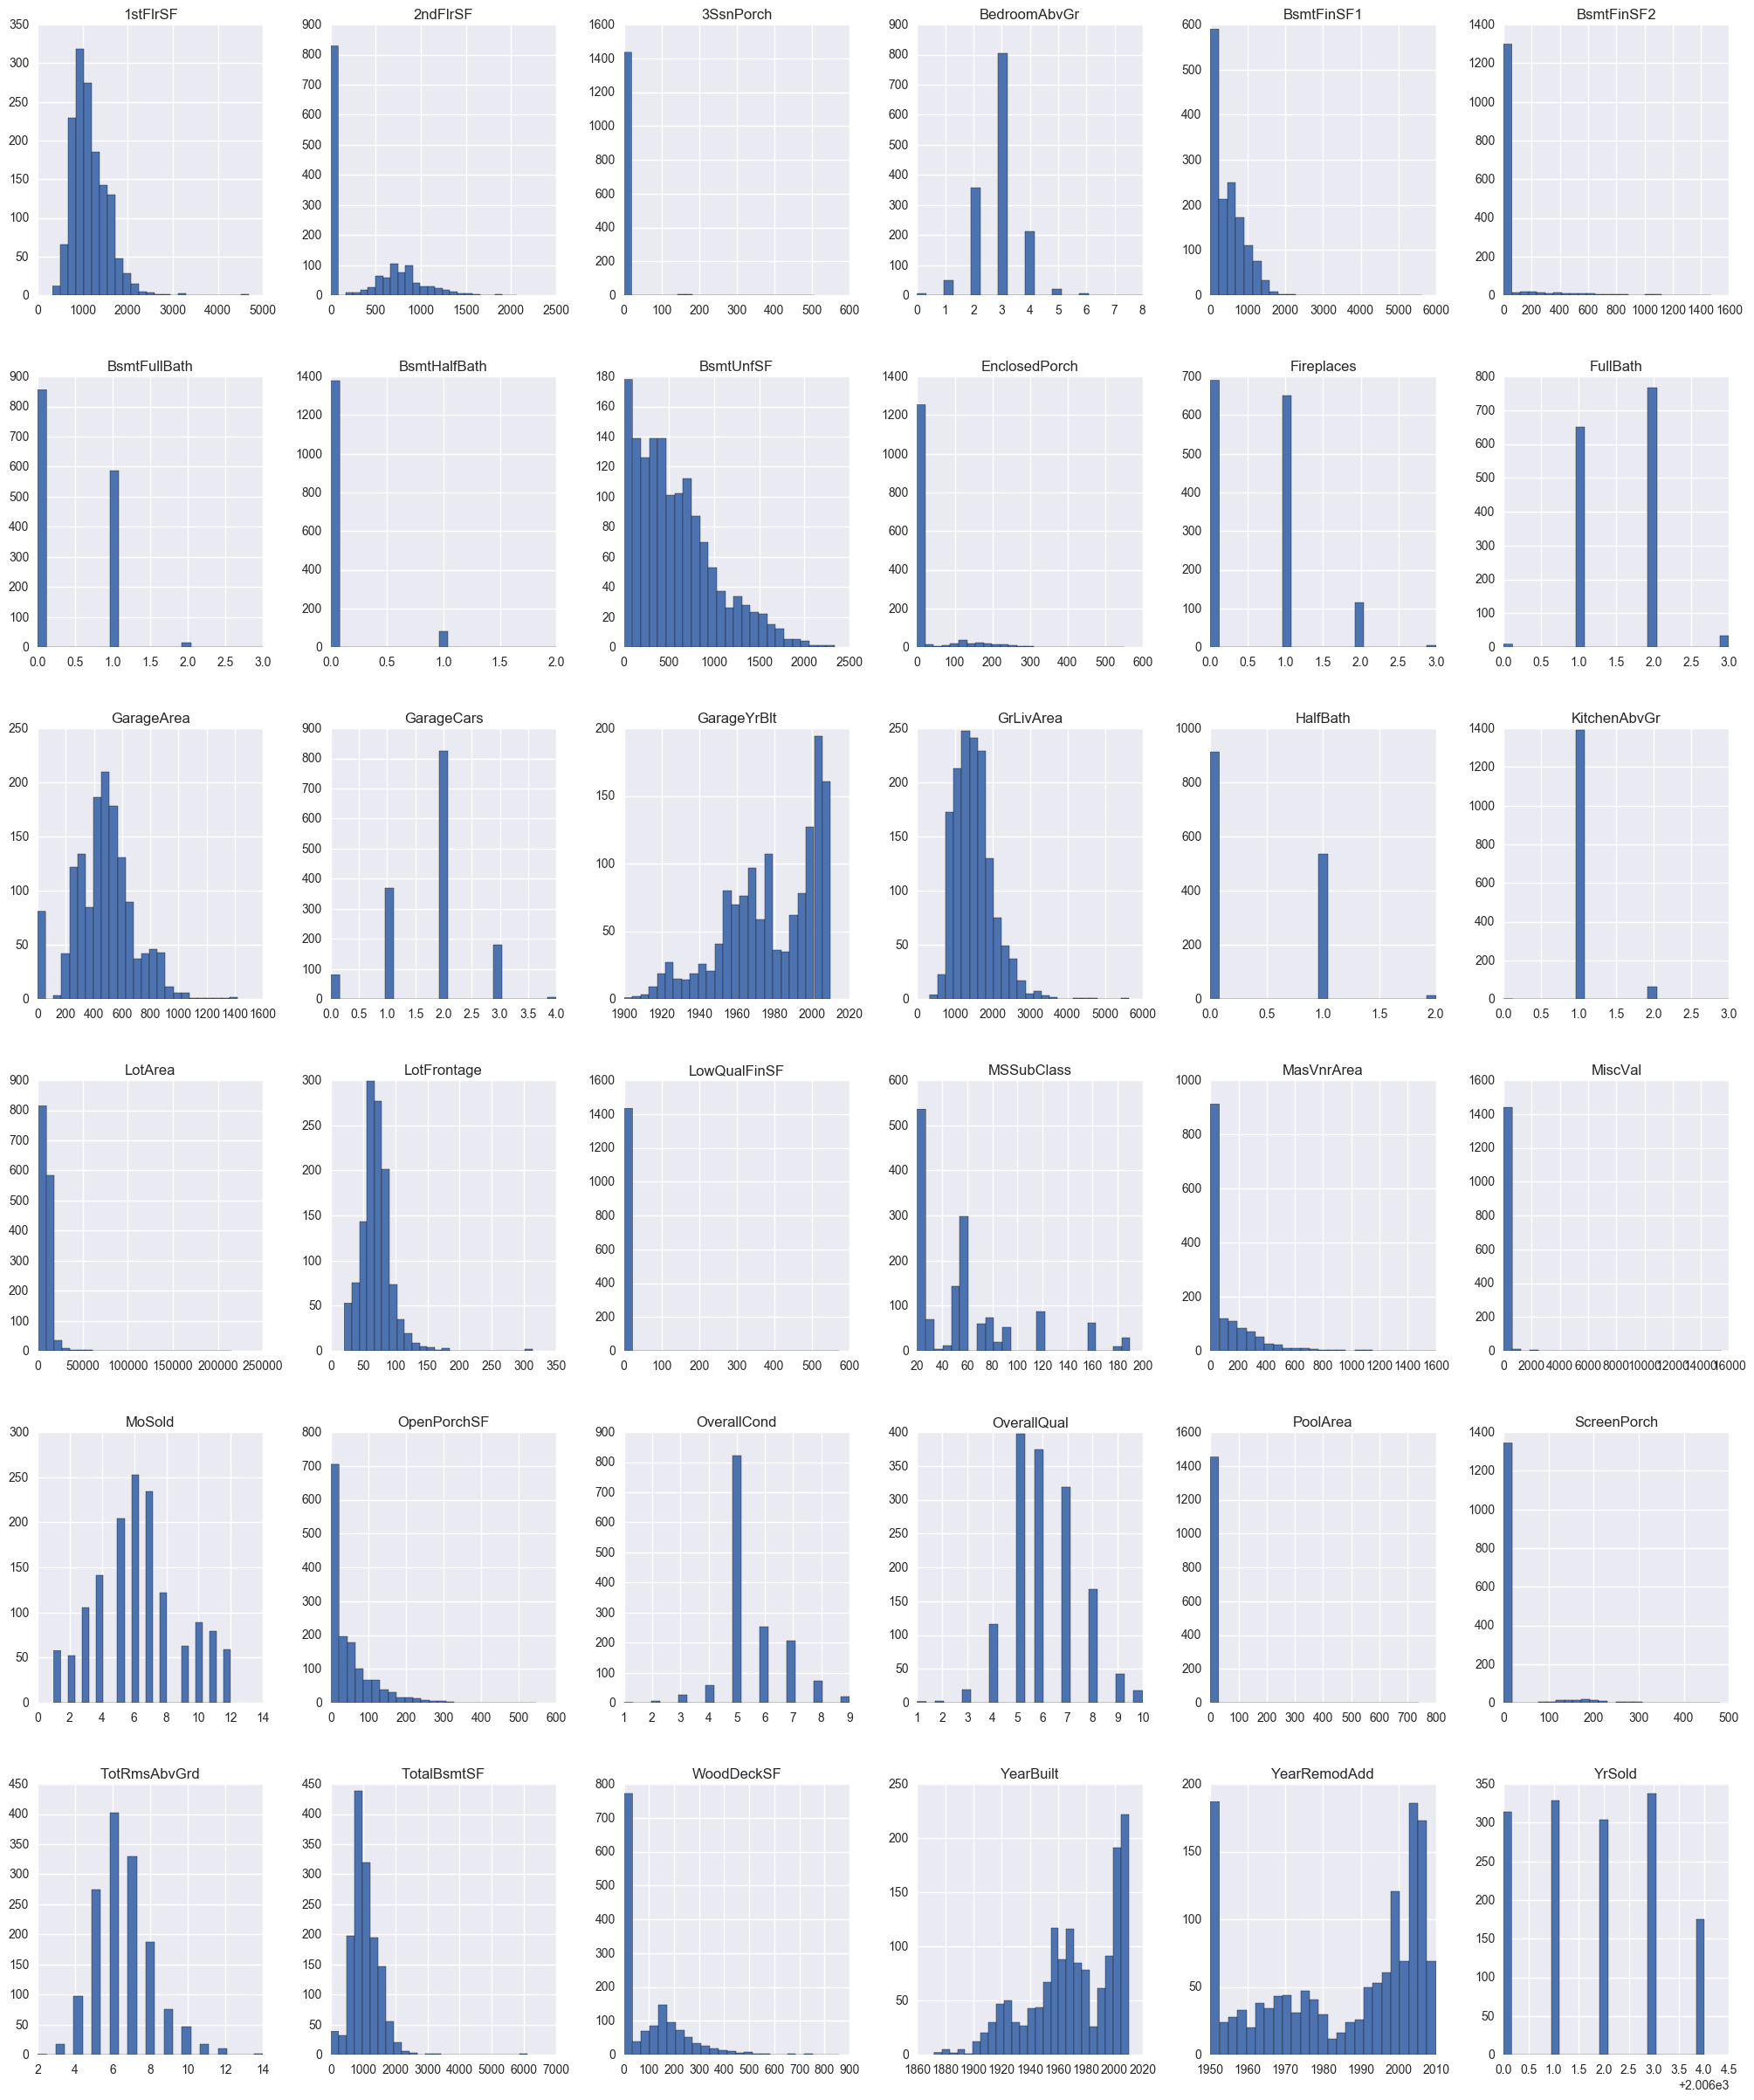

In [65]:
X_tr.hist(figsize=(25, 30), bins=25);

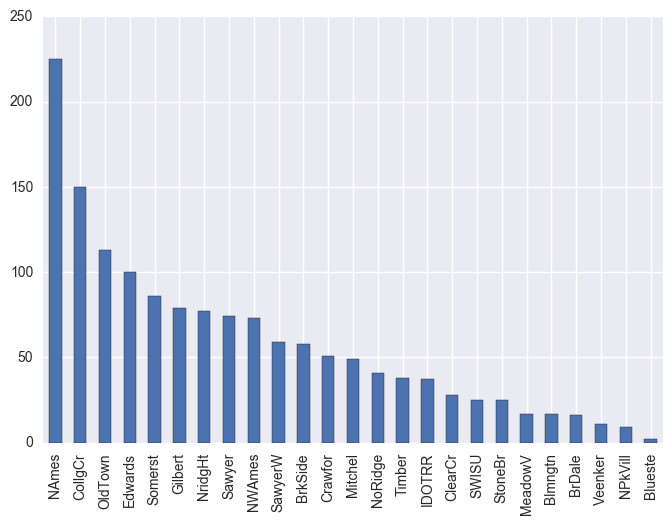

In [66]:
X_tr.Neighborhood.value_counts().plot(kind='bar');

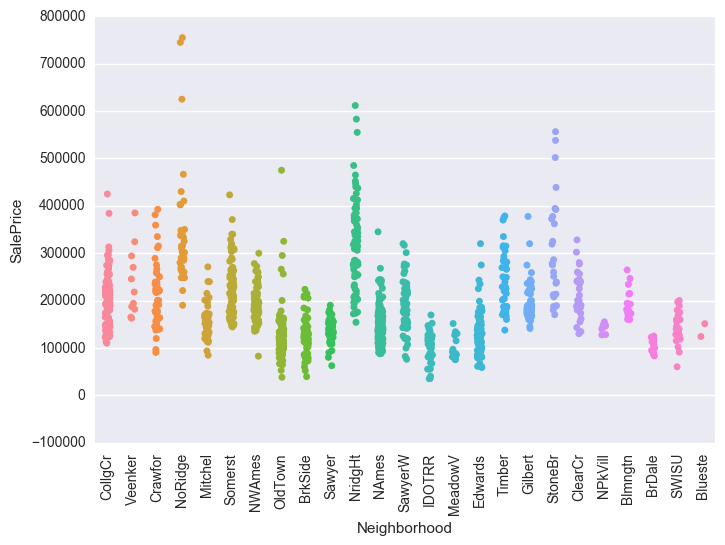

In [67]:
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
sns.stripplot(x="Neighborhood", y="SalePrice", data=train.loc[:,['Neighborhood','SalePrice']],jitter = True)
plt.xticks(rotation=90);

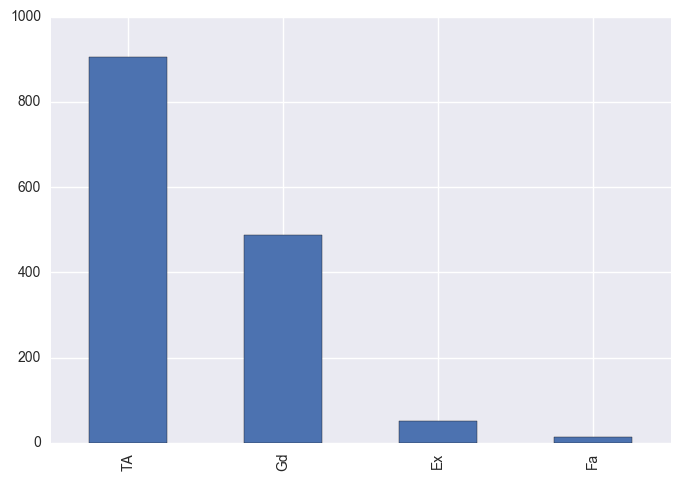

In [68]:
X_tr.ExterQual.value_counts().plot(kind='bar');

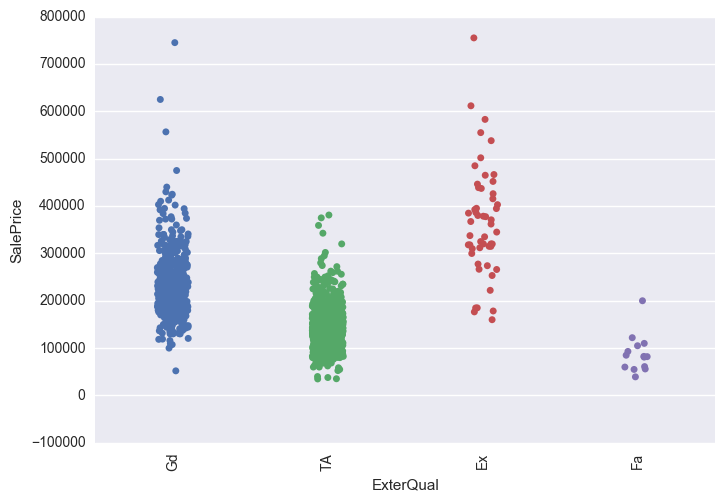

In [69]:
sns.set(style="darkgrid", color_codes=True)
sns.stripplot(x="ExterQual", y="SalePrice", data=train.loc[:,['ExterQual','SalePrice']],jitter = True)
plt.xticks(rotation=90);

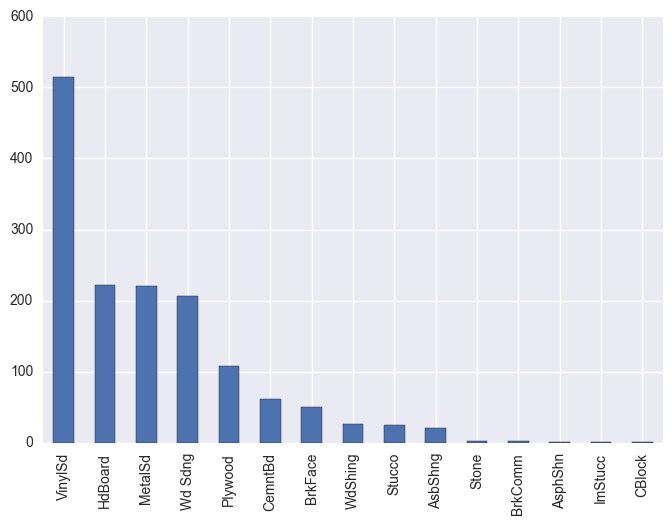

In [70]:
X_tr.Exterior1st.value_counts().plot(kind='bar');

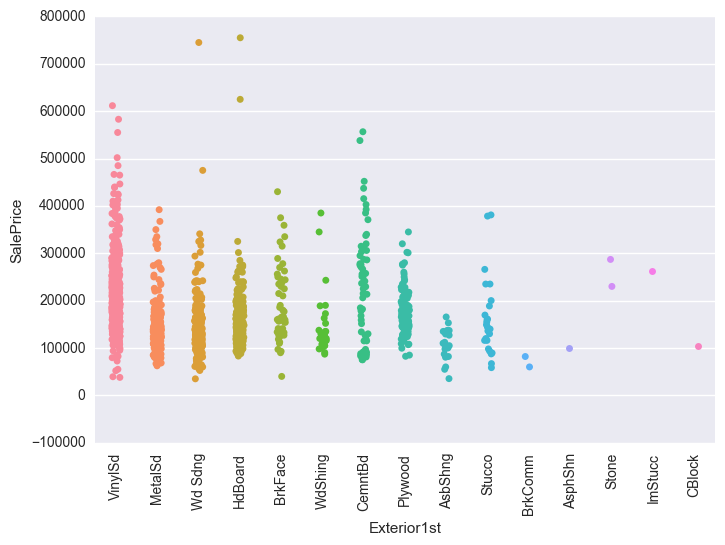

In [71]:
sns.set(style="darkgrid", color_codes=True)
sns.stripplot(x="Exterior1st", y="SalePrice", data=train.loc[:,['Exterior1st','SalePrice']],jitter = True)
plt.xticks(rotation=90);

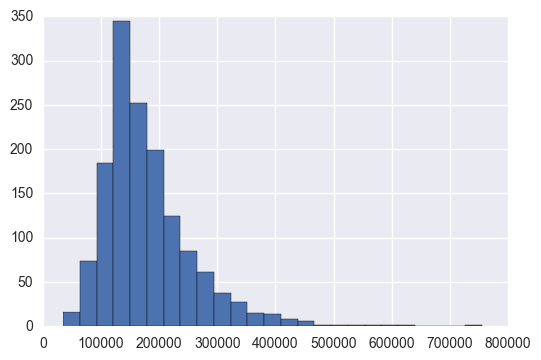

In [17]:
y_tr.hist(bins = 25);

In [18]:
y_tr = np.log(y_train)

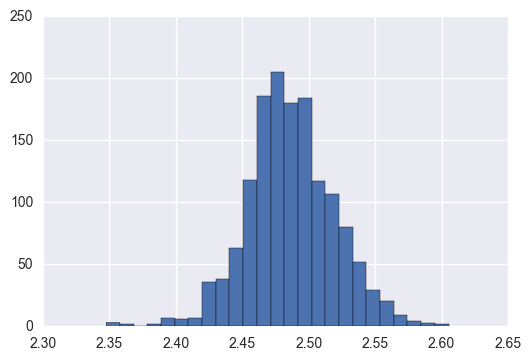

In [19]:
y_tr.hist(bins = 25);

## Features importance

Ici premier algorithme pour détécter l'importance des features à première vue.
Détailler la théorie (article que quentin m'a donné) et le code en dessous.

0.145634151797


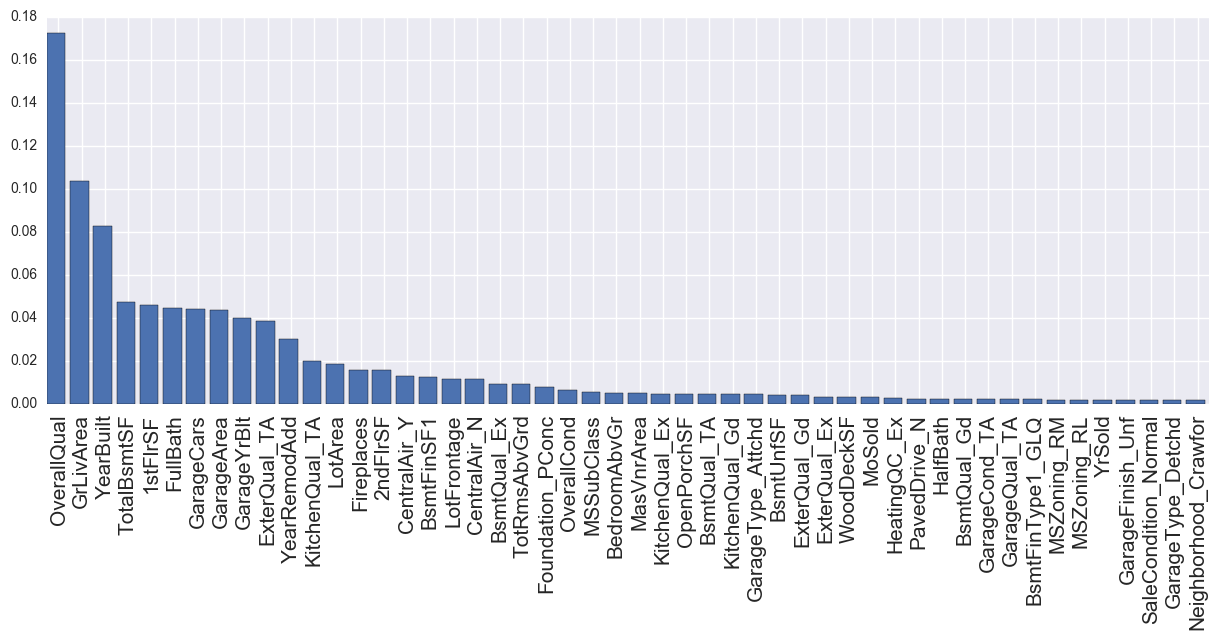

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

X_df = pd.get_dummies(X_tr)
X_df.fillna(X_df.mean(),inplace = True)

plt.figure(figsize=(15, 5))

X = X_df.values
y = y_tr.values
skf = KFold(n_splits = 2,shuffle = True,random_state = 7)

valid_train_is, valid_test_is = list(skf.split(X, y))[0]

X_valid_train = X[valid_train_is]
y_valid_train = y[valid_train_is]
X_valid_test = X[valid_test_is]
y_valid_test = y[valid_test_is]


reg = RandomForestRegressor(n_estimators = 300,max_features = 0.2,max_depth = 12,min_samples_leaf = 2)
reg.fit(X_valid_train, y_valid_train)

print(sqrt(mean_squared_error(y_valid_test,reg.predict(X_valid_test))))

ordering = np.argsort(reg.feature_importances_)[::-1][:50]

importances = reg.feature_importances_[ordering]
feature_names = X_df.columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

Ceci est du texte pour expliquer le graph


# Data preprocessing

blabla

## Symetrize distributions

À voir comment partager entre ici et le 2.1 


## Missing values

petite partie, il y en a pas beaucoup (à vérifier)
on fait simplement remplacement par la moyenne, et pas le plus courrant.
(peut être discuter de l'interet de prendre la moyenne et le plus courant sur test + train ensemble ou en séparé.

## Dealing with cathegorical features


Ici on peut parler des différentes approches, on a choisit get_dummies mais comparer
parler du problème du drop_first ou non, alternative : ajouter la moyenne par quartier blabla

Détailler le code.

## Features engineering

Les features qu'on a essayé d'ajouter, le pourquoi.
peut être parler de la binarisation des variables continues

# Prices predictions

blabla

## Evaluation of our model performances

parler de la cross validation difficile car pas trop de données.
Bien faire le preprocessing pour ne pas biaiser l'estimation (ne pas mettre directement la moyenne des prix ou la moyennes a été pris sur tout le train set.
mettre le code

In [9]:
from sklearn.model_selection import KFold
from preprocess import Preprocess

def crossVal(model,X,y,cv = 5):
    Kfold = KFold(n_splits=cv,shuffle=True,random_state=7)
    prep = Preprocess()
    res = []
    for train,test in  Kfold.split(X,y):
        X_train, X_test, y_train, y_test = X.iloc[train,:],X.iloc[test,:],y.iloc[train,:],y.iloc[test,:]
        prep.fit(X_train,y_train)
        X_train = prep.transform(X_train,X_cat.iloc[train,:])
        X_test = prep.transform(X_test,X_cat.iloc[test,:])
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        res.append(RMSE(y_test['SalePrice'],y_pred))
    return np.mean(res)

## Linear models

parler de lasso, de ridge de elastic net, balancer toute la théorie qu'on a dessus vu en stats et en ML2.
Parler de Adaptative Lasso.

## Random Forests 

parler de random forests, la théorie, mettre le truc de kegl derrière

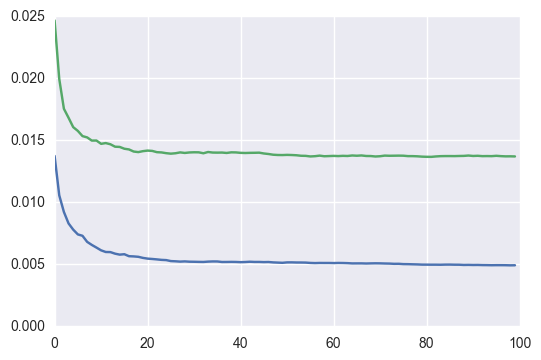

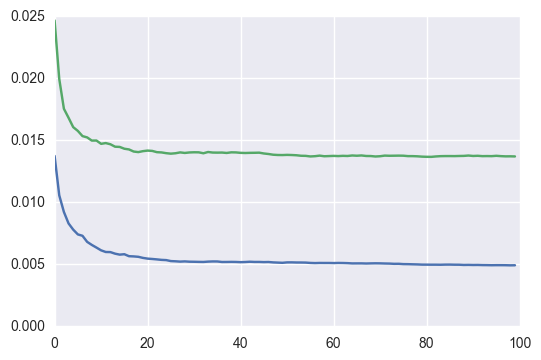

In [35]:
import pylab as pyl
from time import sleep
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from IPython import display
from math import sqrt

X = pd.get_dummies(X_tr)
X.fillna(X.mean(),inplace = True)

X=X.values
Y = y_tr.values 

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=61)



max_depth = 20 # tree depth
n_trees = 100 # number of trees
max_features = 10 # number of random features at each cut
n_samples = X_train.shape[0]

ts = pyl.arange(n_trees)
training_errors = []
test_errors = []
y_pred_train = np.zeros(len(y_train))
y_pred_test = np.zeros(len(y_test))

for t in range(n_trees):
    # Your code should go here
    train = np.random.choice(range(X_train.shape[0]),X_train.shape[0])
    clf = DecisionTreeRegressor(max_features = max_features,max_depth = 20)
    clf.fit(X_train[train,:],y_train[train])
    pyl.clf()
    y_pred_train = (y_pred_train*t + clf.predict(X_train))/(t+1)
    y_pred_test = (y_pred_test*t + clf.predict(X_test))/(t+1)
    training_error = sqrt(mean_squared_error(y_pred_train,y_train))
    test_error = sqrt(mean_squared_error(y_pred_test,y_test))
    training_errors.append(training_error)
    test_errors.append(test_error)
    pyl.plot(ts[:t+1], training_errors[:t+1])
    pyl.plot(ts[:t+1], test_errors[:t+1])
    display.clear_output(wait=True)
    display.display(plt.gcf())
    sleep(.001)

## Boosting methods

faire pareil qu'en haut avec adaboost
expliquer théorie derrière gradient boosting


## Combining our models

expliquer les méthodes pour combiner les algos